In [1]:
from pyteomics import mgf
import pandas as pd
import numpy as np
import glob as glob
import os
import matplotlib.pyplot as plt
import networkx as nx
import pingouin as pg
import seaborn as sns
sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
from metatlas.io import feature_tools as ft

In [2]:
# G = nx.read_graphml('../data/structural_clusters_network.graphml')
G = nx.read_graphml('../data/network.graphml')
df = dict(G.nodes(data=True))
df = pd.DataFrame(df).T
df.index.name = 'node_id'
df.reset_index(inplace=True,drop=False)
df.head()
df.columns

Index(['node_id', 'dbe_ai_mod', 'round3_precursor_mz', 'nosc',
       'smiles_identity', 'inchi_key_identity', 'max_matches_identity', 'c',
       'precursor_mz_analog', 'ai', 'n_to_c', 'p_to_c', 'predicted_formula',
       'p', 'name_analog', 'name_identity', 'precursor_mz', 'o_to_c',
       'original_index', 'h', 'n_to_p', 'dbe', 'sum_frag_intensity', 'n',
       'coisolated_precursor_count', 'rt', 'h_to_c', 'dbe_ai',
       'max_frag_intensity', 'max_score_identity',
       'original_p2d2_index_identity', 'estimated_fdr', 'count',
       'formula_identity', 'assumed_adduct', 'max_score_analog',
       'precursor_mz_identity', 'smiles_analog', 'best_match_method_analog',
       'formula_analog', 'original_p2d2_index_analog', 'inchi_key_analog', 's',
       'ai_mod', 'o', 'best_match_method_identity', 'isolated_precursor_mz',
       'mcs_structural_cluster_number', 'mcs_structural_pattern',
       'mcs_similarity'],
      dtype='object')

/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
file = '/global/cfs/cdirs/metatlas/raw_data/egsb/20230403_EB_BGS_107002-011_BIODESERT_Metagenome_EXP120A_C18-EP_USDAY72349'
files = glob.glob(os.path.join(file,'*NEG*.h5'))
files = [f for f in files if not 'exctrl' in f.lower()]
files = [f for f in files if not 'qc' in f.lower()]
# files = [f for f in files if  'sunshine' in f.lower()]
# files = [f for f in files if ('water' in f) | ('MeOH' in f)]


files = pd.DataFrame(files,columns=['filename'])
# files = files[files['filename'].isin(files_to_use)]
files['experiment'] = files['filename'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[4:6]))
files['sampletype'] = files['filename'].apply(lambda x: x.split('/')[-1].split('_')[12])
# # files['sampletype'] = files['filename'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[12:15]))
# print(files['experiment'].unique())
# # experiments = ['Permafrost_pilot', 'SoilWetDry_final',
#        # 'GEODES_All3', 'FRCgw2_20230830','OMTSoil50g_Pilot']
# # files = files[files['experiment'].isin(experiments)]
files['sampletype'].unique()

files
# files

,filename,experiment,sampletype
0,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,USA-Salas-JornadaLTER-3PLL-2GZM
1,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,USA-Munson-Parker-1PLH-2GZM
2,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,PRT-Nunes-Grandola-2PLM-2GZM
3,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,PRT-Nunes-CompanhiadasLezirias-1PLH-2GZM
4,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,ZAF-Ruppert-KrugerPark-3PLL-2GZM
...,...,...,...
197,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,ZAF-Makhalanyane-Lichtenburg-2PLM-2GZM
198,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,NAM-Wang-Tsamsvlei-3PLL-2GZM
199,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,KEN-Wamiti-Kalama-3PLL-2GZM
200,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,BRA-Conceicao-Barra-3PLL-2GZM


In [58]:

ppm_tolerance = 10
mz_tol = 0.002
rt_min = 1
rt_max = 7

atlas = df[['node_id','precursor_mz']].copy()
atlas.rename(columns={'precursor_mz':'mz','node_id':'label'},inplace=True)
atlas['rt_min'] = rt_min
atlas['rt_max'] = rt_max
atlas['mz_tolerance'] = mz_tol
atlas['rt_tolerance'] = 100
atlas['ppm_tolerance'] = ppm_tolerance
atlas['extra_time'] = 0
atlas['rt_peak'] = (rt_min+rt_max)/2  
atlas['group_index'] = ft.group_consecutive(atlas['mz'].values[:],
                                    stepsize=ppm_tolerance,
                                    do_ppm=True)

out = []
counter = 0
for f in files['filename']:
    try:
        d = ft.get_atlas_data_from_file(f,atlas,desired_key='ms1_neg')
    except:
        print('Can not read',f)
        continue
    d = d[d['in_feature']==True].groupby('label').apply(ft.calculate_ms1_summary).reset_index()
    d['filename'] = f
    out.append(d)
    counter += 1
    print(counter)
out = pd.concat(out)
out.rename(columns={'label':'node_id'},inplace=True)

out

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202


,node_id,num_datapoints,peak_area,peak_height,mz_centroid,rt_peak,filename
0,0.0,951.0,1.003579e+08,6.132042e+06,187.097137,3.543425,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...
1,1.0,498.0,3.257717e+07,3.918768e+05,347.185278,4.378860,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...
2,10.0,210.0,7.932036e+06,6.016686e+05,188.100493,3.537758,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...
3,100.0,74.0,9.842131e+05,6.749220e+04,275.055000,4.553658,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...
4,1000.0,333.0,1.227883e+07,1.423834e+05,295.117730,3.820810,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...
...,...,...,...,...,...,...,...
3126,994.0,126.0,1.692443e+06,3.816911e+04,325.056196,2.367748,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...
3127,995.0,7.0,6.816994e+04,1.679135e+04,261.041832,3.273221,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...
3128,996.0,384.0,1.299796e+07,2.070084e+05,271.081666,2.834597,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...
3129,997.0,8.0,2.317281e+05,5.211050e+04,583.369325,5.988518,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...


In [67]:
out['experiment'] = out['filename'].apply(lambda x: '_'.join(x.split('/')[-1].split('_')[4:6]))
out['sampletype'] = out['filename'].apply(lambda x: x.split('/')[-1].split('_')[12])
out['Trent ID'] = out['filename'].apply(lambda x: os.path.basename(x).split('_')[11])
out['Trent ID'] = out['Trent ID'].astype(int)
# df['treatment'] = df['sampletype'].apply(lambda x: x.split('-')[2])
# df['treatment_control'] = df['sampletype'].apply(lambda x: x.split('-')[3])
# df['metadata_merge_key'] = df['sampletype'].apply(lambda x: '-'.join(x.split('-')[1:4])[:-3]) # researcher last name - site - grazing number
out['metadata_merge_key'] = out['sampletype'].apply(lambda x: '-'.join(x.split('-')[2:4])[:-3]) # site - grazing number
out['metadata_merge_key'] = out['metadata_merge_key'].apply(lambda x: x.lower())
out
# out['sampletype1'] = out['filename'].apply(lambda x: '-'.join(x.split('/')[-1].split('_')[12].split('-')[1:]))
# # out['sampletype2'] = out['filename'].apply(lambda x: x.split('/')[-1].split('_')[14].split('-')[3])
# g = out.groupby('filename')['peak_area'].median()
# g.sort_values(ascending=False,inplace=True)
# g.head(20).to_csv('ones_that_are_big.csv')

,node_id,num_datapoints,peak_area,peak_height,mz_centroid,rt_peak,filename,experiment,sampletype,Trent ID,metadata_merge_key
0,0.0,951.0,1.003579e+08,6.132042e+06,187.097137,3.543425,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,USA-Salas-JornadaLTER-3PLL-2GZM,265,jornadalter-3
1,1.0,498.0,3.257717e+07,3.918768e+05,347.185278,4.378860,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,USA-Salas-JornadaLTER-3PLL-2GZM,265,jornadalter-3
2,10.0,210.0,7.932036e+06,6.016686e+05,188.100493,3.537758,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,USA-Salas-JornadaLTER-3PLL-2GZM,265,jornadalter-3
3,100.0,74.0,9.842131e+05,6.749220e+04,275.055000,4.553658,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,USA-Salas-JornadaLTER-3PLL-2GZM,265,jornadalter-3
4,1000.0,333.0,1.227883e+07,1.423834e+05,295.117730,3.820810,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,USA-Salas-JornadaLTER-3PLL-2GZM,265,jornadalter-3
...,...,...,...,...,...,...,...,...,...,...,...
3126,994.0,126.0,1.692443e+06,3.816911e+04,325.056196,2.367748,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,ARG-Quiroga-SanNicolas-2PLM-2GZM,20,sannicolas-2
3127,995.0,7.0,6.816994e+04,1.679135e+04,261.041832,3.273221,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,ARG-Quiroga-SanNicolas-2PLM-2GZM,20,sannicolas-2
3128,996.0,384.0,1.299796e+07,2.070084e+05,271.081666,2.834597,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,ARG-Quiroga-SanNicolas-2PLM-2GZM,20,sannicolas-2
3129,997.0,8.0,2.317281e+05,5.211050e+04,583.369325,5.988518,/global/cfs/cdirs/metatlas/raw_data/egsb/20230...,BIODESERT_Metagenome,ARG-Quiroga-SanNicolas-2PLM-2GZM,20,sannicolas-2


In [56]:
out.loc[~out['metadata_merge_key'].isin(metadata_df['metadata_merge_key']),'sampletype'].unique()
# for k in out['metadata_merge_key'].unique():
    # n = sum(metadata_df['metadata_merge_key']==k)
    # if n != 1:
        # print(k,n)

array(['USA-Salas-JornadaLTER-3PLL-2GZM', 'USA-Munson-Parker-1PLH-2GZM',
       'PRT-Nunes-Grandola-2PLM-2GZM',
       'PRT-Nunes-CompanhiadasLezirias-1PLH-2GZM',
       'ZAF-Ruppert-KrugerPark-3PLL-2GZM', 'IRN-Farzam-Darkesh-1PLH-2GZM',
       'NER-Malamissam-Tamou-1PLH-2GZM', 'ARG-Yahdjian-Central-1PLH-2GZM',
       'ARG-Yahdjian-Occidental-3PLL-2GZM',
       'ZAF-Makhalanyane-Lichtenburg-3PLL-2GZM',
       'KEN-Wamiti-Rumuruti-1PLH-2GZM', 'IRN-Abedi-Lohondor-1PLH-2GZM',
       'PRT-Durn-Freixo-3PLL-2GZM', 'ESP-Rey-Monsul-3PLL-2GZM',
       'DZA-Fateh-HassiBahbah-2PLM-2GZM',
       'ESP-Moreno-Monfrague-2PLM-2GZM',
       'NAM-Wang-Gemsbokwater-2PLM-2GZM', 'NAM-Wang-Tsamsvlei-1PLH-2GZM',
       'ESP-Moreno-Monfrague-3PLL-2GZM',
       'ZAF-Linstdter-LondonFarm-3PLL-2GZM', 'CHN-Wang-CHA-3PLL-2GZM',
       'USA-Bowker-Needles-2PLM-2GZM',
       'ECU-DelCastillo-Crucita-1PLH-2GZM',
       'ZAF-Ruppert-MaraExperimentalFarm-2PLM-2GZM',
       'IRN-Farzam-Khage-3PLL-2GZM', 'ECU-Espinosa-Za

In [76]:
hiseq_map = pd.read_csv('/global/cfs/cdirs/metatlas/projects/biodesert/ID_BIODESERT_Trent_Hiseq Info.xlsx - Hoja1.csv')
hiseq_map.rename(columns={'Plot/Grazing (1:high, 2:medium; 3: low; 4:non grazing)':'grazing_level'},inplace=True)

out = pd.merge(out,hiseq_map,on='Trent ID',how='left')
out.drop(columns=['Trent ID','Maestre ID Lab-code ', 'Unnamed: 3'],inplace=True)
out.columns = [c.lower() for c in out.columns]
out.columns

Index(['node_id', 'num_datapoints', 'peak_area', 'peak_height', 'mz_centroid',
       'rt_peak', 'filename', 'experiment', 'sampletype', 'metadata_merge_key',
       ...
       'decomposition', 'water', 'erosion', 'below_div', 'hiseq id', 'country',
       'responsible', 'site', 'grazing_level', 'micr'],
      dtype='object', length=335)

In [71]:
metadata_df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/biodesert/Global_Biodesert_02052023 - data.csv', decimal=",")
metadata_df.columns = [c.lower() for c in metadata_df.columns]
metadata_df = metadata_df[pd.notna(metadata_df['site'])]
# metadata_df['metadata_merge_key'] = metadata_df.apply(lambda row: '%s-%s-%d'%(row['res'].lower().split(',')[0],row['site'].replace(' ','').lower(),row['graz']),axis=1)
metadata_df['metadata_merge_key'] = metadata_df.apply(lambda row: '%s-%d'%(row['site'].replace(' ','').lower(),row['plot']),axis=1)
metadata_df = metadata_df[metadata_df['metadata_merge_key'].isin(out['metadata_merge_key'].unique())]
metadata_df.columns = [c.lower() for c in metadata_df.columns]
# df.loc[~df['metadata_merge_key'].isin(metadata_df['metadata_merge_key']),'sampletype'].unique()
# for k in df['metadata_merge_key'].unique():
#     n = sum(metadata_df['metadata_merge_key']==k)
#     if n != 1:
#         print(k,n)
# out = pd.merge(out,metadata_df,on='metadata_merge_key',how='inner')
# out

In [69]:
out['metadata_merge_key'].unique()

array(['jornadalter-3', 'parker-1', 'grandola-2',
       'companhiadaslezirias-1', 'krugerpark-3', 'darkesh-1', 'tamou-1',
       'central-1', 'occidental-3', 'lichtenburg-3', 'rumuruti-1',
       'lohondor-1', 'freixo-3', 'monsul-3', 'hassibahbah-2',
       'monfrague-2', 'gemsbokwater-2', 'tsamsvlei-1', 'monfrague-3',
       'londonfarm-3', 'cha-3', 'needles-2', 'crucita-1',
       'maraexperimentalfarm-2', 'khage-3', 'zapotillo-2',
       'maraexperimentalfarm-3', 'baharkish-2', 'sair-3', 'syferkuil-1',
       'sayeretshaked-3', 'subandine-2', 'muri-3', 'khage-2',
       'casanova-3', 'viljoenskroon-2', 'ciempozuelos-2', 'mata-2',
       'monsul-2', 'guelbfguira-1', 'beitnir-3', 'yuyang-1',
       'companhiadaslezirias-3', 'hassibahbah-3', 'sonop-1', 'lohondor-3',
       'beitnir-2', 'muri-1', 'puertodelascoberteras-2', 'baharkish-3',
       'casanova-2', 'banonuevo-1', 'mostaza-1', 'galed-1',
       'viljoenskroon-3', 'sayeretshaked-2', 'krugerpark-2', 'page-2',
       'elouassria-

In [74]:
out = pd.merge(out,metadata_df,on='metadata_merge_key',how='inner')

In [97]:
microbe_df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/biodesert/Biodesert_microbe_id.csv', decimal=",")
microbe_df.columns = [c.lower() for c in microbe_df.columns]
microbe_df = microbe_df[pd.notna(microbe_df['site'])]

microbe_df['metadata_merge_key'] = microbe_df.apply(lambda row: '%s-%d'%(row['site'].replace(' ','').lower(),row['plot']),axis=1)
microbe_df = microbe_df[['metadata_merge_key','id_microbes']]
microbe_df['id_microbes'] = microbe_df['id_microbes'].apply(lambda x: x.lower())
print(out.shape)
out = pd.merge(out,microbe_df,on='metadata_merge_key',how='inner')
print(df.shape)

(629466, 335)
(3235, 50)


In [147]:
kegg_ko_df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/biodesert/Biodesert_Community_Level/KEGG_table_ko-tpm_normalizedvalues.csv', decimal=",")
kegg_ko_df.columns = [c.lower() for c in kegg_ko_df.columns]

kegg_ko_df.drop(columns=['level1','level2','level3'],inplace=True)
kegg_ko_df.set_index('id',drop=True,inplace=True)


kegg_ko_df = kegg_ko_df.T
# cazy_df = cazy_df + 1
# cazy_df.index.name = 'microbe_id'
kegg_ko_df = kegg_ko_df[kegg_ko_df.index.isin(out['id_microbes'])]

kegg_ko_df = kegg_ko_df.T

kegg_ko_df = kegg_ko_df[kegg_ko_df.max(axis=1)>10]

m = kegg_ko_df.min(axis=1)
for c in kegg_ko_df.columns:
    kegg_ko_df[c] = kegg_ko_df[c] - m
    
m = kegg_ko_df.max(axis=1)
for c in kegg_ko_df.columns:
    kegg_ko_df[c] = kegg_ko_df[c] / m


kegg_ko_df

,fm001,fm002,fm003,fm004,fm005,fm006,fm007,fm008,fm010,fm011,...,fm253,fm254,fm256,fm257,fm258,fm260,fm261,fm263,fm264,fm265
id,,,,,,,,,,,,,,,,,,,,,
K00001,0.265306,0.255102,0.431973,0.363946,0.404762,0.632653,0.585034,0.574830,0.333333,0.302721,...,0.350340,0.312925,0.588435,0.428571,0.299320,0.629252,0.496599,0.551020,0.530612,0.486395
K00002,0.181818,0.545455,0.272727,0.272727,0.272727,0.181818,0.181818,0.090909,0.090909,0.181818,...,0.181818,0.272727,0.363636,0.272727,0.181818,0.090909,0.363636,0.363636,0.454545,0.454545
K00003,0.825000,0.212500,0.325000,0.475000,0.337500,0.537500,0.900000,0.825000,0.725000,0.637500,...,0.462500,0.287500,0.562500,0.787500,0.612500,0.450000,0.375000,0.487500,0.712500,0.562500
K00004,0.123711,0.195876,0.144330,0.257732,0.175258,0.329897,0.247423,0.195876,0.237113,0.360825,...,0.309278,0.309278,0.391753,0.360825,0.432990,0.453608,0.484536,0.443299,0.391753,0.443299
K00005,0.181818,0.272727,0.272727,0.227273,0.409091,0.272727,0.272727,0.272727,0.136364,0.090909,...,0.454545,0.590909,0.181818,0.181818,0.136364,0.227273,0.136364,0.136364,0.090909,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K22476,0.080000,0.040000,0.100000,0.200000,0.180000,0.300000,0.140000,0.200000,0.220000,0.340000,...,0.080000,0.300000,0.500000,0.220000,0.300000,0.200000,0.500000,0.380000,0.320000,0.300000
K22477,0.250000,0.350000,0.250000,0.450000,0.150000,0.250000,0.250000,0.150000,0.600000,0.800000,...,0.300000,0.600000,0.050000,0.300000,0.150000,0.250000,0.350000,0.150000,0.250000,0.400000
K22478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [98]:
cazy_df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/biodesert/Biodesert_Community_Level/CAZy_table.csv', decimal=",")
cazy_df.columns = [c.lower() for c in cazy_df.columns]

cazy_df.drop(columns=['description'],inplace=True)
cazy_df.set_index('cazy',drop=True,inplace=True)
cazy_df = cazy_df.T
cazy_df = cazy_df + 1
cazy_df.index.name = 'microbe_id'
cazy_df = cazy_df[cazy_df.index.isin(out['id_microbes'])]

cazy_df = cazy_df.T

cazy_df = cazy_df[cazy_df.max(axis=1)>10]

m = cazy_df.min(axis=1)
for c in cazy_df.columns:
    cazy_df[c] = cazy_df[c] - m
    
m = cazy_df.max(axis=1)
for c in cazy_df.columns:
    cazy_df[c] = cazy_df[c] / m

cazy_df

microbe_id,fm001,fm002,fm003,fm004,fm005,fm006,fm007,fm008,fm010,fm011,...,fm253,fm254,fm256,fm257,fm258,fm260,fm261,fm263,fm264,fm265
cazy,,,,,,,,,,,,,,,,,,,,,
AA10,0.109091,0.109091,0.290909,0.145455,0.236364,0.327273,0.127273,0.072727,0.054545,0.018182,...,0.181818,0.109091,0.327273,0.200000,0.109091,0.327273,0.109091,0.345455,0.254545,0.127273
CBM42,0.133333,0.044444,0.044444,0.044444,0.044444,0.066667,0.200000,0.177778,0.133333,0.022222,...,0.022222,0.022222,0.400000,0.355556,0.222222,0.088889,0.333333,0.133333,0.288889,0.355556
CBM48,0.299712,0.190202,0.438040,0.351585,0.412104,0.538905,0.412104,0.498559,0.236311,0.296830,...,0.340058,0.314121,0.743516,0.755043,0.636888,0.766571,0.573487,0.547550,0.714697,0.585014
CBM50,0.428571,0.321429,0.464286,0.321429,0.214286,0.285714,0.214286,0.178571,0.142857,0.000000,...,0.178571,0.214286,0.250000,0.107143,0.142857,0.178571,0.214286,0.285714,0.250000,0.107143
CE1,0.346154,0.538462,0.750000,0.557692,0.673077,0.480769,0.134615,0.250000,0.153846,0.307692,...,0.480769,0.288462,0.346154,0.307692,0.288462,0.423077,0.269231,0.269231,0.288462,0.192308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GT85,0.172414,0.137931,0.241379,0.206897,0.137931,0.206897,0.241379,0.137931,0.068966,0.137931,...,0.172414,0.103448,0.137931,0.275862,0.310345,0.137931,0.172414,0.103448,0.206897,0.137931
GT87,0.193103,0.255172,0.275862,0.275862,0.179310,0.275862,0.075862,0.048276,0.013793,0.013793,...,0.200000,0.248276,0.317241,0.248276,0.234483,0.158621,0.172414,0.248276,0.262069,0.158621
GT89,0.133333,0.100000,0.133333,0.100000,0.166667,0.100000,0.200000,0.100000,0.166667,0.233333,...,0.166667,0.133333,0.133333,0.166667,0.100000,0.066667,0.100000,0.066667,0.100000,0.100000


In [128]:
i_cols = ['node_id']
p = pd.pivot_table(data=out,index=i_cols,values='peak_area',columns=['id_microbes'],fill_value=None)#[['value','sample_grazing']])
p = p + 1
p = p[pd.notna(p).all(axis=1)]
p = p[p.max(axis=1)>1e6]
p = np.log10(p)

m = p.min(axis=1)
for c in p.columns:
    p[c] = p[c] - m
m = p.max(axis=1)
for c in p.columns:
    p[c] = p[c] / m

p

id_microbes,fm001,fm002,fm003,fm004,fm005,fm006,fm007,fm008,fm010,fm011,...,fm253,fm254,fm256,fm257,fm258,fm260,fm261,fm263,fm264,fm265
node_id,,,,,,,,,,,,,,,,,,,,,
0.0,0.421477,0.273211,0.176511,0.635713,0.442179,0.419788,0.515669,0.663379,0.672555,0.809341,...,0.457460,0.260906,0.387309,0.426702,0.305475,0.528589,0.511249,0.000000,0.053888,0.159223
1.0,0.235534,0.140197,0.213938,0.185939,0.151234,0.148587,0.448181,0.712170,0.227604,0.496003,...,0.141554,0.234900,0.220014,0.205075,0.164387,0.176223,0.173829,0.171560,0.198791,0.224327
10.0,0.455980,0.304179,0.196868,0.659216,0.480619,0.442676,0.548833,0.692570,0.698376,0.827641,...,0.494472,0.292282,0.419404,0.459031,0.342823,0.565362,0.546786,0.011723,0.077383,0.200784
100.0,0.338897,0.037932,0.448152,0.419344,0.293110,0.329447,0.687133,0.526640,0.689666,0.733415,...,0.497343,0.572950,0.414779,0.478168,0.310933,0.657394,0.426384,0.167961,0.071170,0.191978
1000.0,0.165659,0.016404,0.209590,0.350941,0.236592,0.222899,0.396341,0.436196,0.336316,0.399345,...,0.206470,0.432646,0.266192,0.245824,0.188818,0.189201,0.209245,0.037657,0.072100,0.026238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99.0,0.320768,0.091884,0.305584,0.272902,0.140106,0.336530,0.462039,0.410696,0.498368,0.531387,...,0.469675,0.645807,0.454162,0.362843,0.443112,0.411470,0.411683,0.133115,0.094609,0.204937
990.0,0.318245,0.188043,0.385086,0.459524,0.347418,0.290053,0.564403,0.684151,0.392768,0.444244,...,0.323437,0.521962,0.371968,0.322280,0.283998,0.273050,0.312397,0.078202,0.146427,0.126593
994.0,0.459641,0.262124,0.481508,0.714882,0.888609,0.451900,0.772991,0.688396,0.799246,0.815530,...,0.676455,0.728249,0.658543,0.561442,0.480542,0.785004,0.604024,0.190966,0.000000,0.235015


In [129]:
from copy import deepcopy
# a = deepcopy(kegg_ko_df)
a = deepcopy(cazy_df)
metabolites = p[a.columns].values
# enzymes = cazy_df.values
enzymes = a.values

metabolites = [m - m.mean() for m in metabolites]
enzymes = [m - m.mean() for m in enzymes]

met_norm = np.asarray([np.linalg.norm(m) for m in metabolites])
enzyme_norm = np.asarray([np.linalg.norm(m) for m in enzymes])

# metabolites = p[a.columns].values**0.5
# enzymes = a.values**0.5

metabolites = metabolites / met_norm[:,None]
enzymes = enzymes / enzyme_norm[:,None]

metabolites.shape,enzymes.shape

((2378, 201), (64, 201))

In [130]:
d  = np.dot(metabolites,enzymes.T)
d[~np.isfinite(d)] = 0
met_idx, enz_idx = np.unravel_index(d.argmax(), d.shape)

In [133]:
met_idx, enz_idx = np.unravel_index(d.argmin(), d.shape)
p.iloc[met_idx].name,cazy_df.iloc[enz_idx].name

('1251.0', 'CE10')

[[ 1.         -0.58865978]
 [-0.58865978  1.        ]]


Text(0, 0.5, 'Enzyme Level (a.u.)')

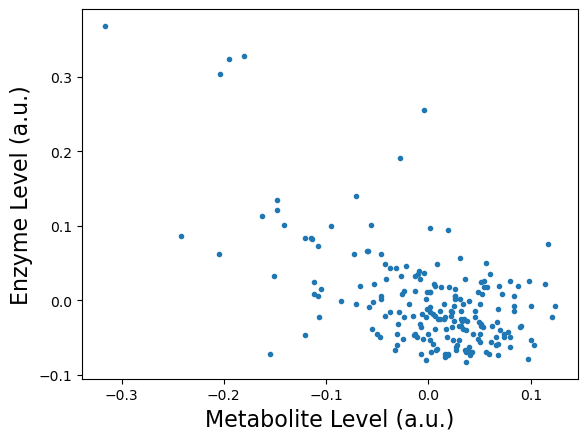

In [134]:
x = metabolites[met_idx,:]
y = enzymes[enz_idx,:]
print(np.corrcoef(x,y))
fig, ax = plt.subplots()
ax.plot(x,y,'.')
ax.set_xlabel('Metabolite Level (a.u.)',fontsize=16)
ax.set_ylabel('Enzyme Level (a.u.)',fontsize=16)

In [191]:
def setup_dataframe(out,cols=['grazing_level']):
    d = out.pivot_table(columns=['filename']+cols,index=['node_id'],values='peak_area',aggfunc='mean',fill_value=300)

    # temp = d.T
    # temp.columns = [f"{index[1]}-{index[0]}" for index in temp.columns]
    d = d.apply(shannon_diversity_index,axis=0)
    d = d.to_frame()
    d.reset_index(inplace=True,drop=False)
    d.rename(columns={0:'shannon_diversity_index'},inplace=True)
    # d['treatment'] = d['filename'].apply(lambda x: os.path.basename(x).split('_')[12].split('-')[1])
    # d['depth'] = d['filename'].apply(lambda x: os.path.basename(x).split('_')[12].split('-')[-1])

    # Make treatment a categorical variable and put it in order
    # c = ['unbdp', 'omt', 'grass', 'cmt', 'rwc']
    # c = [cc.upper() for cc in c]
    # d['treatment'] = pd.Categorical(d['treatment'], categories=c, ordered=True)
    return d


def shannon_diversity_index(m,threshold=1e7,q=2):
    m = m>threshold
    probabilities = m / m.sum()
    shannon_diversity_index = -np.sum(probabilities * np.log2(probabilities))
    return shannon_diversity_index
    # probabilities = m / m.sum()
    # hill_number = np.sum(probabilities**q)**(1/(1-q))
    # return hill_number

# cols=['grazing_level']+metadata_df.columns.tolist()
# cols = list(set(cols) - set(['site','plot','metadata_merge_key']))
d = setup_dataframe(out,cols=['id_microbes'])
d.drop(columns=['filename'],inplace=True)
d.set_index('id_microbes',inplace=True)
p = d.T
# p = pd.pivot_table(data=d,index='node_id',values='peak_area',columns=['id_microbes'],fill_value=None)#[['value','sample_grazing']])
# p = p + 1
p = p[pd.notna(p).all(axis=1)]
from copy import deepcopy
a = deepcopy(kegg_ko_df)
# a = deepcopy(cazy_df)
metabolites = p[a.columns].values
# enzymes = cazy_df.values
enzymes = a.values

metabolites = [m - m.mean() for m in metabolites]
enzymes = [m - m.mean() for m in enzymes]

met_norm = np.asarray([np.linalg.norm(m) for m in metabolites])
enzyme_norm = np.asarray([np.linalg.norm(m) for m in enzymes])

# metabolites = p[a.columns].values**0.5
# enzymes = a.values**0.5

metabolites = metabolites / met_norm[:,None]
enzymes = enzymes / enzyme_norm[:,None]

d  = np.dot(metabolites,enzymes.T)
d[~np.isfinite(d)] = 0
corr_df = pd.DataFrame(d,index=p.index,columns=a.index)
# met_idx, enz_idx = np.unravel_index(d.argmax(), d.shape)
corr_df =  corr_df.T
corr_df.columns = ['correlation']
corr_df.sort_values('correlation',inplace=True)
corr_df

/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,correlation
id,
K02824,-0.473408
K14534,-0.462725
K01854,-0.459852
K05710,-0.437058
K16784,-0.436309
...,...
K07123,0.393174
K07085,0.401009
K01580,0.441236


[[1.         0.48587183]
 [0.48587183 1.        ]]


Text(0, 0.5, 'Enzyme Level (a.u.)')

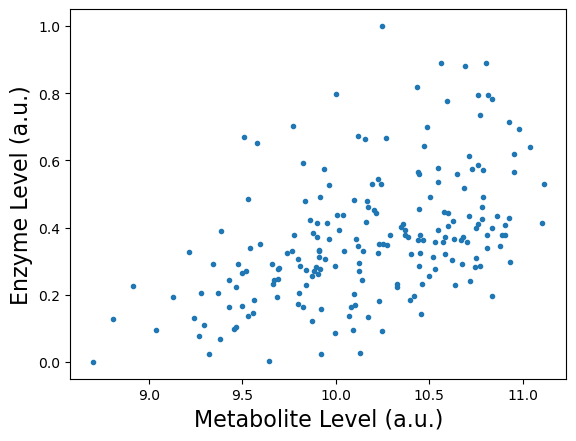

In [192]:
y = a.loc['K02003',:]
# y = a.loc['K05710',:]
x = p[a.columns].values.flatten()
print(np.corrcoef(x,y))
fig, ax = plt.subplots()
ax.plot(x,y,'.')
ax.set_xlabel('Metabolite Level (a.u.)',fontsize=16)
ax.set_ylabel('Enzyme Level (a.u.)',fontsize=16)

In [194]:
# cazy_df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/biodesert/Biodesert_Community_Level/CAZy_table.csv', decimal=",")
# cazy_df.columns = [c.lower() for c in cazy_df.columns]

# cazy_df.drop(columns=['description'],inplace=True)
# cazy_df.set_index('cazy',drop=True,inplace=True)
# cazy_df = cazy_df.T
# cazy_df = cazy_df + 1
# cazy_df.index.name = 'microbe_id'
# cazy_df = cazy_df[cazy_df.index.isin(df['id_microbes'])]

# cazy_df = cazy_df.T

# cazy_df = cazy_df[cazy_df.max(axis=1)>10]

# m = cazy_df.min(axis=1)
# for c in cazy_df.columns:
#     cazy_df[c] = cazy_df[c] - m
    
# m = cazy_df.max(axis=1)
# for c in cazy_df.columns:
#     cazy_df[c] = cazy_df[c] / m

# cazy_df

In [195]:
d = setup_dataframe(out, cols=['metadata_merge_key'])
d.drop(columns=['filename'], inplace=True)
d.set_index('metadata_merge_key', inplace=True)
p = d.T
# p = pd.pivot_table(data=d,index='node_id',values='peak_area',columns=['id_microbes'],fill_value=None)#[['value','sample_grazing']])
# p = p + 1
p = p[pd.notna(p).all(axis=1)]
from copy import deepcopy
# a = deepcopy(kegg_ko_df)
# a = deepcopy(cazy_df)
a = deepcopy(metadata_df.set_index('metadata_merge_key').select_dtypes(include='number'))
a = a.T
metabolites = p[a.columns].values
enzymes = a.values
# enzymes = cazy_df.values
# enzymes = a.values

metabolites = [m - m.mean() for m in metabolites]
enzymes = [m - m.mean() for m in enzymes]

met_norm = np.asarray([np.linalg.norm(m) for m in metabolites])
enzyme_norm = np.asarray([np.linalg.norm(m) for m in enzymes])

# metabolites = p[a.columns].values**0.5
# enzymes = a.values**0.5

metabolites = metabolites / met_norm[:,None]
enzymes = enzymes / enzyme_norm[:,None]

d  = np.dot(metabolites,enzymes.T)
d[~np.isfinite(d)] = 0
corr_df = pd.DataFrame(d,index=p.index,columns=a.index)
# met_idx, enz_idx = np.unravel_index(d.argmax(), d.shape)
corr_df =  corr_df.T
corr_df.columns = ['correlation']
corr_df.sort_values('correlation',inplace=True)
corr_df.head(10)

/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2030971/3471096881.py:28: RuntimeWarning: invalid value encountered in divide
  enzymes = enzymes / enzyme_norm[:,None]


,correlation
sac veg,-0.577990
sac b,-0.574996
mdr,-0.546685
aridity,-0.474839
aridity v3,-0.472524
ndvi_max_cv_modis,-0.433160
ele-alos30,-0.366027
ele egm96,-0.365144
mtweq,-0.358998
rase,-0.353966


[[1.         0.67507064]
 [0.67507064 1.        ]]


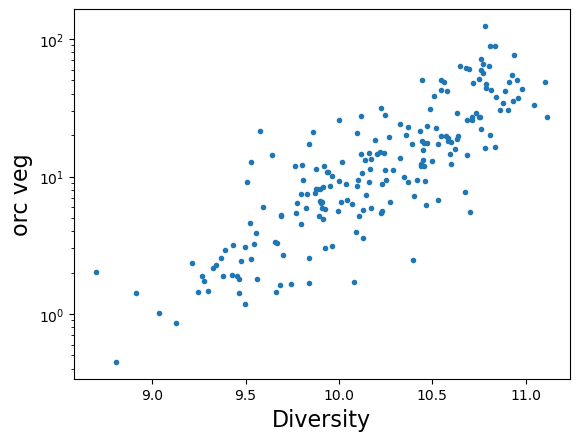

In [199]:
# c = 'fertility'
c = 'orc veg'
# c = 'decomposition'
# c = 'whc b'
# c = 'sac veg'
# c = 'mdr'
# y = a.loc['orc veg',:]
# y = a.loc['aridity v3',:]
y = a.loc[c,:]
# y = a.loc['sac veg',:]
# y = a.loc['sac veg',:]
x = p[a.columns].values.flatten()
print(np.corrcoef(x,y))
fig, ax = plt.subplots()
ax.plot(x,y,'.')
ax.set_xlabel('Diversity',fontsize=16)
ax.set_ylabel(c,fontsize=16)
ax.set_yscale('log')
plt.show()

In [9]:
# pd.pivot_table(out[out['sampletype'].str.contains('UNBDP')],index='node_id',columns='filename',values='peak_area')

In [9]:

# d = out.pivot_table(columns='node_id',index=['depth','environment'],values='peak_area',aggfunc='mean',fill_value=300)
# d.reset_index(inplace=True,drop=False)
# d.shape,len(cluster_strings),Z.shape
out

,node_id,num_datapoints,peak_area,peak_height,mz_centroid,rt_peak,filename,experiment,sampletype,depth,environment
0,0.0,792.0,1.637407e+07,1.244696e+06,187.097245,3.502224,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm,00to20cm,GRASS
1,1.0,110.0,5.924166e+05,9.723118e+03,347.185777,4.842616,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm,00to20cm,GRASS
2,10.0,34.0,9.766242e+05,1.284465e+05,188.100600,3.502224,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm,00to20cm,GRASS
3,100.0,14.0,5.943517e+04,6.323062e+03,275.055490,3.665781,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm,00to20cm,GRASS
4,1000.0,279.0,2.556126e+06,2.180871e+04,295.118291,2.952717,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-GRASS-7d1-00to20cm,00to20cm,GRASS
...,...,...,...,...,...,...,...,...,...,...,...
2854,990.0,314.0,3.234306e+06,6.135586e+04,323.149424,5.559272,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-CMT-4d5-00to20cm,00to20cm,CMT
2855,994.0,2.0,6.956789e+03,3.854128e+03,325.056392,2.971871,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-CMT-4d5-00to20cm,00to20cm,CMT
2856,995.0,3.0,1.655057e+04,7.262154e+03,261.042777,4.052833,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-CMT-4d5-00to20cm,00to20cm,CMT
2857,996.0,222.0,3.008508e+06,7.263563e+04,271.081666,3.370433,/global/cfs/cdirs/metatlas/raw_data/egsb/20231...,CenturyExp_20230414,soil-CMT-4d5-00to20cm,00to20cm,CMT


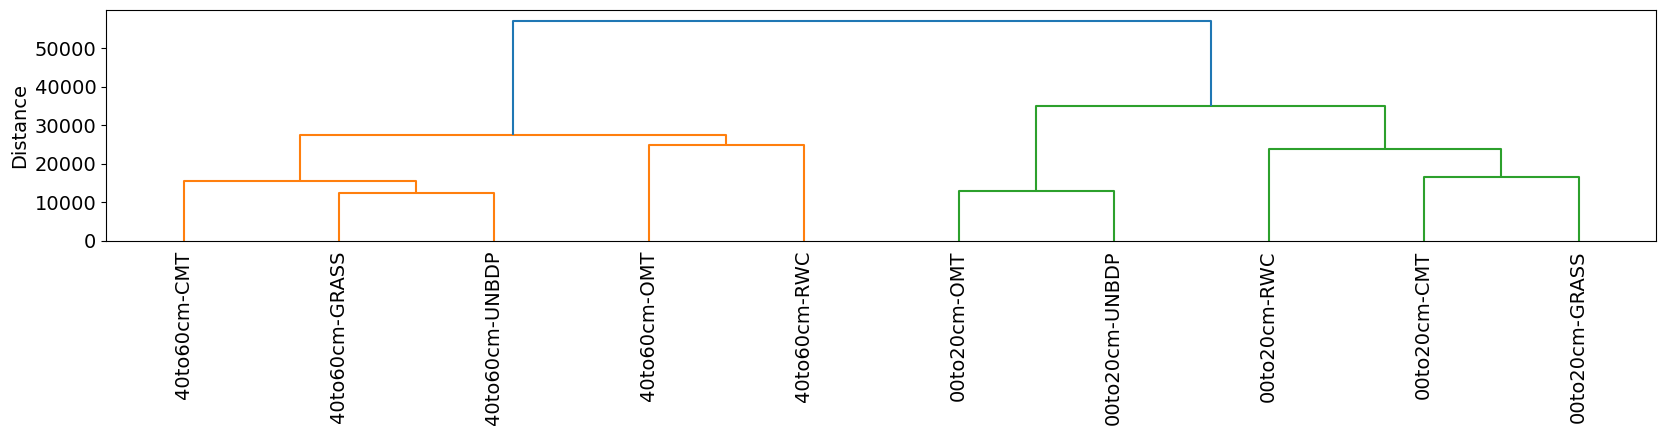

In [14]:
from scipy.cluster.hierarchy import linkage, fcluster
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
# d = setup_dataframe(out)
d = out.pivot_table(index='node_id',columns=['environment','depth'],values='peak_area',aggfunc='mean',fill_value=300)
d.columns = [f"{index[1]}-{index[0]}" for index in d.columns]

cluster_strings = list(d.columns)#[os.path.basename(c).split('_')[12] for c in d.index]

# Perform hierarchical clustering
Z = linkage(d.T.apply(lambda x: x**0.5), method='ward', metric='euclidean')
import matplotlib.pyplot as plt
# Plot the dendrogram
plt.figure(figsize=(20, 3))

clusters = fcluster(Z, 4e4, criterion='distance')
# d['cluster'] = clusters
# cluster_strings = [f"{index[1]}-{index[0]} Cluster {cluster}" for index, cluster in zip(d.index, d['cluster'])]
# cluster_strings = [f"{index} Cluster {cluster}" for index, cluster in zip(d.index, d['cluster'])]

dendrogram(Z, labels=cluster_strings, leaf_font_size=14,color_threshold=4e4,)
# Set plot title and labels
# plt.title("Dendrogram with Depth and Environment Labels")
# plt.xlabel("Samples", fontsize=14)
plt.ylabel("Distance", fontsize=14)

# Set y tick label fontsize
plt.yticks(fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)


# Show the plot
plt.show()


In [26]:
# from rdkit import Chem
# from rdkit.Chem import Draw
# mz = nx.get_node_attributes(G, 'precursor_mz')
# smiles_identity = nx.get_node_attributes(G, 'smiles_identity')
# temp = d.T.copy()
# c1 = 'soil-CentExp-OMT1d2-1130buck-50g'
# c2 = 'soil-Sunshine-Mix4-NA-water'
# temp['fold_change'] = np.log2(temp[c1]/temp[c2])
# temp = pd.merge(temp,pd.DataFrame({'precursor_mz':mz}),left_index=True,right_index=True)

# temp = pd.merge(temp,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
# p = temp[pd.notna(temp['smiles_identity'])]

# p.sort_values('fold_change',ascending=False,inplace=True)
# top_10 = p.head(20)
# bottom_10 = p.tail(20)

# top_mols = [Chem.MolFromSmiles(smiles) for smiles in top_10['smiles_identity']]
# bottom_mols = [Chem.MolFromSmiles(smiles) for smiles in bottom_10['smiles_identity']]
# mols = top_mols + bottom_mols
# image = Draw.MolsToGridImage(mols, subImgSize=(200,200),molsPerRow=10,maxMols=1000,useSVG=True)
# image

In [27]:
# mz = nx.get_node_attributes(G, 'precursor_mz')
# smiles_identity = nx.get_node_attributes(G, 'smiles_identity')

# temp = d.T.copy()
# c1 = 'soil-CentExp-OMT1d2-1130buck-50g'
# c2 = 'soil-Sunshine-Mix4-NA-water'
# temp['fold_change'] = np.log2(temp[c1]/temp[c2])

# temp = pd.merge(temp,pd.DataFrame({'precursor_mz':mz}),left_index=True,right_index=True)
# temp = pd.merge(temp,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
# # p = d[pd.notna(d['smiles_identity'])]
# p = temp.copy()
# fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(15,5),sharey=True,sharex=True)
# ax.vlines(p['precursor_mz'], 0, p[c1]**0.5)
# ax.vlines(p['precursor_mz'], 0, -1*(p[c2]**0.5))
# # ax[1].vlines(p['precursor_mz'], 0, p['fold_change'])
# # ax[2].vlines(p['precursor_mz'], 0, ymax=-1*(p[2]**0.5))

# # ax.set_ylim(-50000,50000)
# ax.grid(True)
# ax.set_xlim(50,650)


In [28]:
# mz = nx.get_node_attributes(G, 'precursor_mz')
# smiles_identity = nx.get_node_attributes(G, 'smiles_identity')

# temp = d.T.copy()
# c1 = 'soil-CentExp-OMT1d2-1130buck-50g'
# c2 = 'soil-Sunshine-Mix4-NA-water'
# temp['fold_change'] = np.log2(temp[c1]/temp[c2])

# temp = pd.merge(temp,pd.DataFrame({'precursor_mz':mz}),left_index=True,right_index=True)
# temp = pd.merge(temp,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
# # p = d[pd.notna(d['smiles_identity'])]
# p = temp.copy()
# fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(15,11),sharey=True,sharex=True)
# ax[0].vlines(p['precursor_mz'], 0, p['fold_change'])


# p = temp[pd.notna(temp['smiles_identity'])]
# ax[1].vlines(p['precursor_mz'], 0, p['fold_change'])
# # ax[2].vlines(p['precursor_mz'], 0, ymax=-1*(p[2]**0.5))


# # for a in ax:
#     # a.set_xlim(270,330)


In [62]:
mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
smiles_identity = nx.get_node_attributes(G, 'smiles_identity')

temp = pd.DataFrame({'cluster':mcs_structural_cluster_number})
temp = pd.merge(temp,pd.DataFrame({'smiles':smiles_identity}),left_index=True,right_index=True)
temp.fillna('',inplace=True)
sig_out = []
val_out = []
for i in temp['cluster'].unique():
    df = pd.merge(out,temp,left_on='node_id',right_index=True)
    # df = df[df['depth']!='litter']
    # df = df[df['depth']!='b']
    # df = df[(df['environment']=='coniferousforests') | (df['environment']=='grasses') ]
    df = df[df['cluster']==i]
    cols = ['environment', 'depth','peak_area','filename','node_id']
    df = df[cols]
    # filename_mapping = {f: i+1 for i, f in enumerate(df['filename'].unique())}
    # df['filename'] = df['filename'].map(filename_mapping)

    # node_id_mapping = {f: i+1 for i, f in enumerate(df['node_id'].unique())}
    # df['node_id'] = df['node_id'].map(node_id_mapping)



    df = pd.pivot_table(df,values='peak_area',index=['filename','environment','depth'],columns=['node_id'],fill_value=300)
    df = df.mean(axis=1).to_frame()
    df.reset_index(inplace=True,drop=False)
    df.rename(columns={0:'peak_area'},inplace=True)
    anova_result = pg.anova(data=df, dv='peak_area', between=['environment', 'depth'])#, subject='filename')
    anova_result['structural_cluster'] = i
    sig_out.append(anova_result)
        # THERE IS A PROBLEM HERE.  OUT SHOULD BE FILTERED TO ONLY STRUCTURAL CLUSTERS

    v = out.groupby(['environment','depth'])['peak_area'].mean().to_frame().reset_index()
    v['structural_cluster'] = i
    val_out.append(v)
sig_out = pd.concat(sig_out)
val_out = pd.concat(val_out)
sig_out = pd.pivot_table(sig_out,values='p-unc',index=['structural_cluster'],columns=['Source'])
sig_out = sig_out[sig_out.min(axis=1)<0.05]
val_out = val_out.pivot_table(index='structural_cluster',columns=['environment','depth'],values='peak_area')
val_out.columns = ['_'.join(c) for c in val_out.columns]
val_out.reset_index(inplace=True,drop=False)
sig_out = pd.merge(sig_out,val_out,left_index=True,right_on='structural_cluster',how='inner')

In [67]:
node_data = pd.pivot_table(out,index=['node_id'],columns=['sampletype','depth'],values='peak_area',aggfunc=np.mean,fill_value=300)
node_data.columns = ['_'.join(c) for c in node_data.columns]

node_data.columns = ['Quant: %s'%c for c in node_data.columns]
backup_G = G.copy()
nx.set_node_attributes(backup_G, node_data.to_dict('index'))
# nx.write_graphml(backup_G,'../data/network_omt-potting.graphml')

In [48]:
node_data = pd.pivot_table(out,index=['node_id'],columns=['depth','environment'],values='peak_area',aggfunc=np.mean,fill_value=300)
node_data.columns = ['%s-%s'%(c[1],c[0]) for c in node_data.columns]

# node_data = node_data.apply(lambda  x: np.log10(x+1),axis=1)
# s = node_data.sum(axis=0).values
# m = s.mean()
# node_data.values[:,:] = m * (node_data.values[:,:]/s)
# node_data.columns = [c.split('/')[-1].split('_')[12] for c in node_data.columns]

# node_data.to_csv('../data/log10_averages_treatments.csv')
node_data
node_data.columns = ['Quant: %s'%c for c in node_data.columns]

n = node_data.copy()
m = n.min(axis=1)
m = n.values - m.values[:,None]
n = pd.DataFrame(m,index=n.index,columns=n.columns)

m = n.max(axis=1)
m = n.values / m.values[:,None]
n = pd.DataFrame(m,index=n.index,columns=n.columns)


original_index = nx.get_node_attributes(G, 'original_index')
mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
mcs_structural_pattern = nx.get_node_attributes(G, 'mcs_structural_pattern')
smiles_identity = nx.get_node_attributes(G, 'smiles_identity')
# temp = {}
# for c in n.columns:
    # temp[c] = nx.get_node_attributes(backup_G, c)

temp = pd.merge(n,pd.DataFrame({'cluster_id':mcs_structural_cluster_number}),left_index=True,right_index=True)
temp = pd.merge(temp,pd.DataFrame({'cluster_pattern':mcs_structural_pattern}),left_index=True,right_index=True)
temp = pd.merge(temp,pd.DataFrame({'smiles_identity':smiles_identity}),left_index=True,right_index=True)
cols = [c for c in temp.columns if 'Quant' in c]
cluster_df = temp.groupby(['cluster_id','cluster_pattern'])[cols].mean()
identity_df = temp.groupby(['cluster_id','cluster_pattern','smiles_identity'])[cols].mean()


In [71]:
import umap
node_data = pd.pivot_table(out,index=['node_id'],columns=['depth','environment'],values='peak_area',aggfunc=np.mean,fill_value=300)
node_data.columns = ['%s-%s'%(c[1],c[0]) for c in node_data.columns]
# Reduce dimensionality using UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(node_data.T)


/global/common/software/m2650/msbuddy/lib/python3.8/site-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [77]:
colors = [col.split('-')[1] for col in node_data.columns]
shapes = [col.split('-')[0] for col in node_data.columns]
pd.unique(colors)

array(['00to20cm', '40to60cm'], dtype=object)

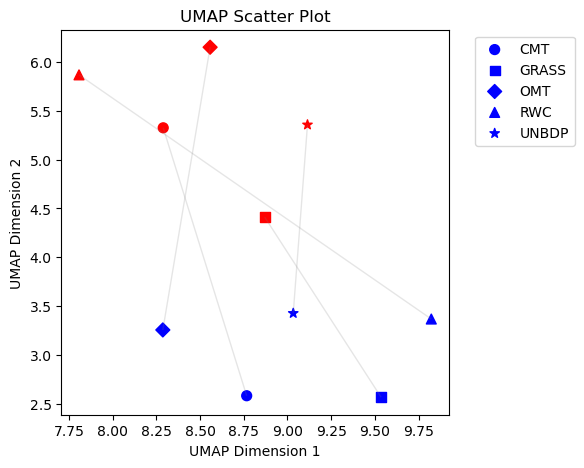

In [79]:

shape_mapping = {'CMT':'o', 'GRASS':'s', 'OMT':'D', 'RWC':'^', 'UNBDP':'*'}
    
    # 'Quant: coniferousforests':'o', 'Quant: deciduousforests':'s',
    # 'Quant: desertshrubs':'D', 'Quant: grasses':'^', 'Quant: mixedforests':'v',
    # 'Quant: tundra':'*'}

colors = [col.split('-')[1] for col in node_data.columns]
shapes = [col.split('-')[0] for col in node_data.columns]
color_mapping = {'00to20cm':'b', '40to60cm':'r'}
# 'a': 'purple', 'b': 'blue', 'c': 'cyan'}  # Add your color mapping here

# Convert categorical values to actual shapes
actual_shapes = [shape_mapping[shape] for shape in shapes]

# Convert categorical values to actual colors
actual_colors = [color_mapping[color] for color in colors]


# fig, ax = plt.subplots(figsize=(5, 5))
# for i in range(embedding.shape[0]):
#     ax.scatter(embedding[i, 0], embedding[i, 1],s=50, c=actual_colors[i], marker=actual_shapes[i], label='%s-%s' % (shapes[i], colors[i]))

# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig, ax = plt.subplots(figsize=(5, 5))

# Group the markers by shape
shape_groups = node_data.columns.to_series().groupby(shapes)

for shape, group in shape_groups:
    # Get the indices of the markers with the same shape
    indices = [i for i, col in enumerate(node_data.columns) if col.split('-')[0] == shape]
    
    # Get the colors of the markers with the same shape
    shape_colors = [actual_colors[i] for i in indices]
    
    # Get the coordinates of the markers with the same shape
    shape_coords = embedding[indices]
    
    # Draw shaded regions around markers with the same shape
    ax.scatter(shape_coords[:, 0], shape_coords[:, 1], s=50, c=shape_colors, marker=shape_mapping[shape], label=shape)
    ax.fill(shape_coords[:, 0], shape_coords[:, 1], facecolor='none', edgecolor='gray', alpha=0.2)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Scatter Plot')
plt.show()


# plt.xlabel('UMAP Dimension 1')
# plt.ylabel('UMAP Dimension 2')
# plt.title('UMAP Scatter Plot')
# plt.show()



In [80]:
import seaborn as sns
cols = identity_df.columns
c = 0
x_labels = [col.replace('Quant: ','') for col in cols]
from PIL import Image
from io import BytesIO
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol)#,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)
temp = cluster_df.copy()
# cols = [c for c in temp.columns if 'litter' not in c]
# temp = temp[cols]
temp.reset_index(inplace=True,drop=False)
temp.set_index('cluster_id',inplace=True,drop=True)
temp.drop(columns=['cluster_pattern'],inplace=True)
temp = temp[temp.index.isin(sig_out.loc[sig_out['environment']<0.05,'structural_cluster'].values)].copy()

num_unique_clusters = temp.shape[0]


# temp.reset_index(inplace=True,drop=True)
temp.columns = [c.replace('Quant: ','') for c in temp.columns]
# temp = temp.apply(lambda x: x/x.sum(),axis=1)
# fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(20,20))
                      
sns.clustermap(temp,cmap='jet',method='ward')
#     ax[c].set_title('Cluster %d'%d.iloc[0]['cluster_id'])
#     counter = 0
#     for i, row in d.iterrows():

#         mol = Chem.MolFromSmiles(row['smiles_identity'])
#         d2d = Draw.MolDraw2DCairo(120, 120)
#         dopts = d2d.drawOptions()
#         dopts.setBackgroundColour((0, 0, 0, 0))
#         im = show_mol(d2d, mol)

#         imagebox = OffsetImage(im, zoom=0.8)
#         ax[c].add_artist(AnnotationBbox(imagebox, (-1, counter+0.5), frameon=False,annotation_clip=False))#,box_alignment=(0,0)))
        
#         counter += 1
#     c += 1
#     # if c>6:
#         # break
    
# plt.tight_layout()

# # Set the x-axis labels for the bottom row of subplots
# for i in range(n_cols):
#     ax[-n_cols + i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)

# # Set the x-axis label for the entire figure
# # fig.text(0.5, 0.04, 'Identity', ha='center', fontsize=14)

# plt.tight_layout()
# fig.savefig('../data/identity_heatmap_cornel-pnas.pdf')

# cluster_df

NameError: name 'identity_df' is not defined

27


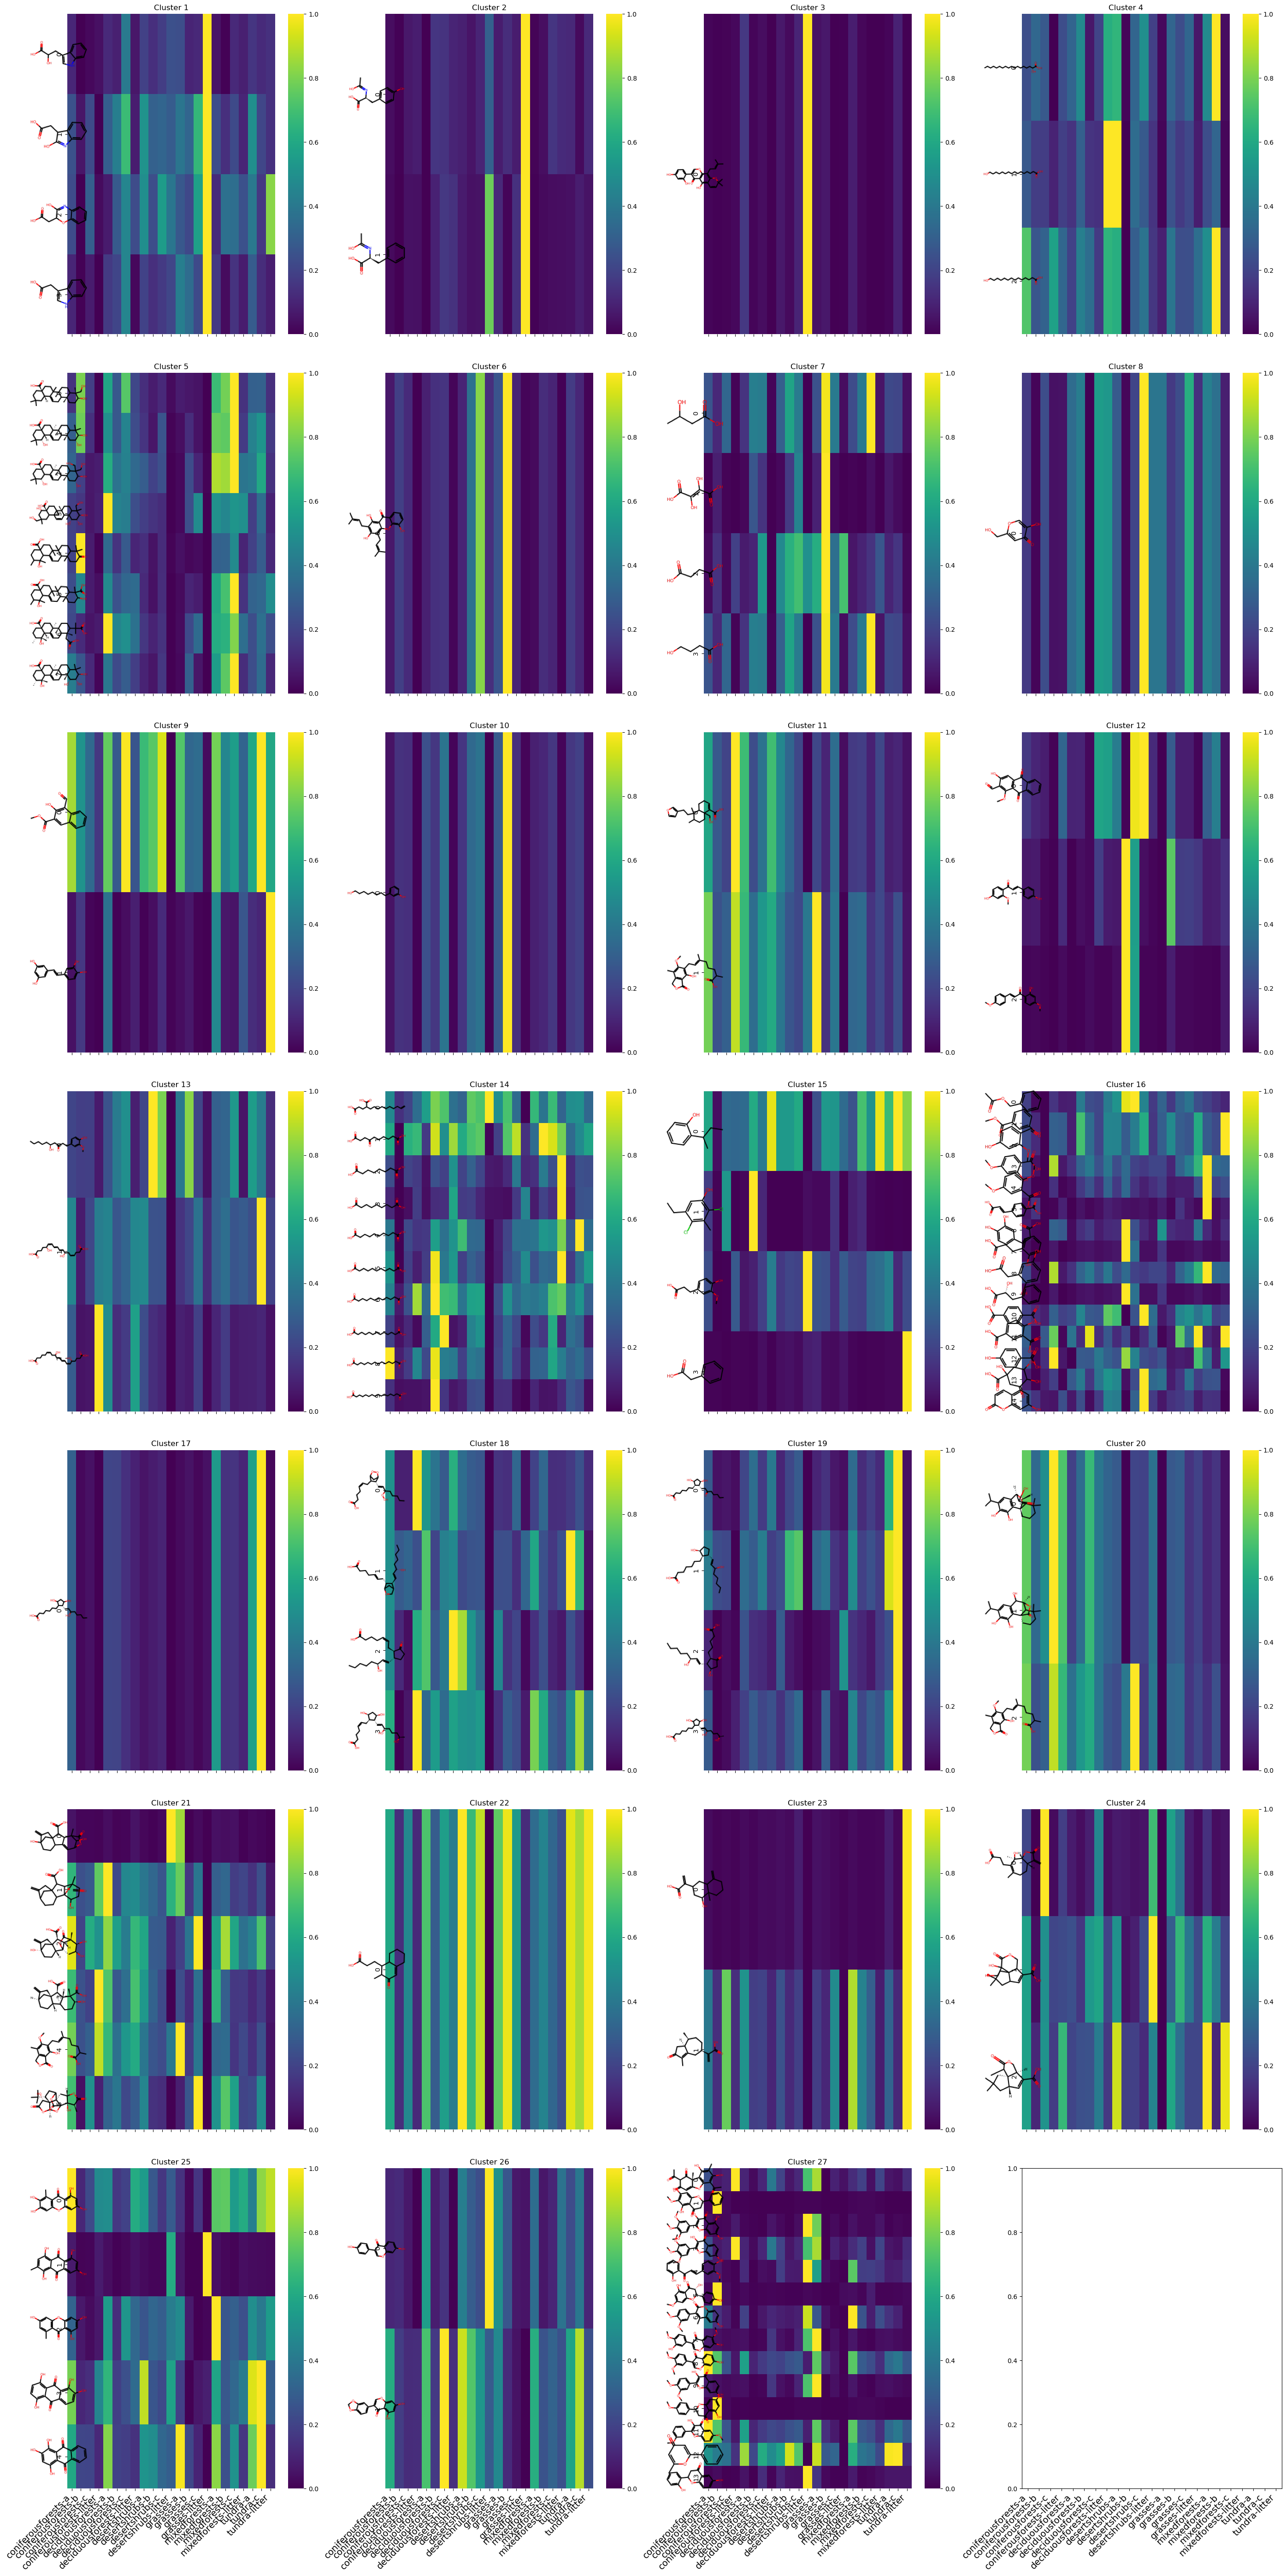

In [12]:
import seaborn as sns
cols = identity_df.columns
c = 0
x_labels = [col.replace('Quant: ','') for col in cols]
from PIL import Image
from io import BytesIO
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def show_mol(d2d,mol,legend='',highlightAtoms=[]):
    d2d.DrawMolecule(mol)#,legend=legend, highlightAtoms=highlightAtoms)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

num_unique_clusters = identity_df.index.get_level_values('cluster_id').nunique()
print(num_unique_clusters)
n_cols = 4
n_rows = int(np.ceil(num_unique_clusters/n_cols))

fig,ax = plt.subplots(nrows=n_rows,ncols=4,figsize=(n_rows*4,n_cols*14),sharex=True,sharey=False)
                      
ax = ax.flatten()
for _,d in identity_df.reset_index(drop=False).groupby('cluster_id'):
    
    sns.heatmap(d[cols].values,ax=ax[c],cmap='viridis')
    ax[c].set_title('Cluster %d'%d.iloc[0]['cluster_id'])
    counter = 0
    for i, row in d.iterrows():

        mol = Chem.MolFromSmiles(row['smiles_identity'])
        d2d = Draw.MolDraw2DCairo(120, 120)
        dopts = d2d.drawOptions()
        dopts.setBackgroundColour((0, 0, 0, 0))
        im = show_mol(d2d, mol)

        imagebox = OffsetImage(im, zoom=0.8)
        ax[c].add_artist(AnnotationBbox(imagebox, (-1, counter+0.5), frameon=False,annotation_clip=False))#,box_alignment=(0,0)))
        
        counter += 1
    c += 1
    # if c>6:
        # break
    
plt.tight_layout()

# Set the x-axis labels for the bottom row of subplots
for i in range(n_cols):
    ax[-n_cols + i].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=14)

# Set the x-axis label for the entire figure
# fig.text(0.5, 0.04, 'Identity', ha='center', fontsize=14)

plt.tight_layout()
fig.savefig('../data/identity_heatmap_cornel-pnas.pdf')


In [49]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculate the pairwise distances between rows
cols = [c for c in cluster_df.columns if ('deciduousforests' in c) | ('coniferousforests' in c)]
distances = cluster_df.values

# Perform hierarchical clustering
Z = linkage(distances, method='average', metric='euclidean')

# Get the order of the rows based on the clustering
order = dendrogram(Z, no_plot=True)['leaves']

# Reorder the rows of cluster_df
cluster_df = cluster_df.iloc[order]

# Show the reordered cluster_df
cluster_df[cols]


,
cluster_id,cluster_pattern
6,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])=&!@[#6&!R]-&!@[#6&!R]-&!@[#6&R]1:&@[#6&R](-&!@[#8&!R]):&@[#6&R](-&!@[#6&!R]-&!@[#6&!R]=&!@[#6&!R](-&!@[#6&!R])-&!@[#6&!R]):&@[#6&R]2:&@[#6&R](:&@[#6&R]:&@1-&!@[#8&!R]):&@[#6&R](:&@[#6&R]1:&@[#6&R](:&@[#8&R]:&@2):&@[#6&R](-&!@[#8&!R]):&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1)=&!@[#8&!R]
17,[#8&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1-&!@[#6&!R](=&!@[#8&!R])-&!@[#6&!R]=&!@[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@[#6&R]:&@1)-&!@[#8&!R]
12,[#8&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@1)-&!@[#8&!R]
3,[#6&R]1:&@[#6&R]:&@[#6&R](-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R]):&@[#6&R]:&@[#6&R]:&@[#7&R]:&@1
8,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]
11,[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R]
4,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]
10,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]
28,[#8&!R]=&!@[#6&R]1:&@[#6&R](-&!@[#6&R]2:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@2):&@[#6&R]:&@[#8&R]:&@[#6&R]2:&@[#6&R]:&@1:&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@2)-&!@[#8&!R]


In [71]:
X

array([[0.        , 0.1517823 ],
       [0.01820346, 0.09378591],
       [0.14752172, 0.32650793],
       [0.15322819, 0.11647638],
       [0.18375165, 0.07533162],
       [0.18584564, 0.21711498],
       [0.19393477, 0.13607873],
       [0.20796583, 0.22048184],
       [0.23337573, 0.17250905],
       [0.27471707, 0.5984838 ],
       [0.29919257, 0.22149301],
       [0.31368427, 0.14270419],
       [0.31647659, 0.34771622],
       [0.32273487, 0.33485659],
       [0.34649859, 0.54230661],
       [0.36039766, 0.42064533],
       [0.38729162, 0.35341481],
       [0.40015129, 0.48007851],
       [0.48951501, 0.40138409],
       [0.53350194, 0.66460197],
       [0.54042921, 0.48435572],
       [0.54564604, 0.51645713],
       [0.57430751, 0.48472693],
       [0.61194921, 0.51527161],
       [0.62346483, 0.57032746],
       [0.62522843, 0.58805734],
       [0.67345078, 0.64129989],
       [0.73105995, 0.5570944 ],
       [0.92679136, 0.69191462]])

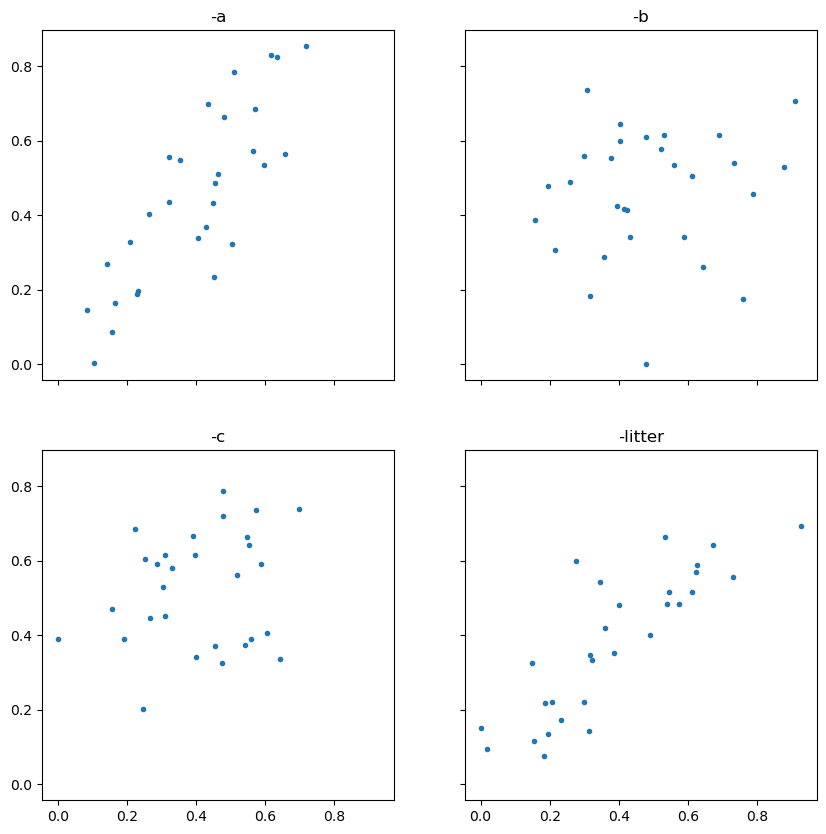

In [74]:
cols = [c for c in cluster_df.columns if ('deciduousforests' in c) | ('coniferousforests' in c)]
temp = cluster_df[cols].copy()
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(10,10),sharex=True,sharey=True)
ax = ax.flatten()
counter = 0
for depth in ['-a','-b','-c','-litter']:
    cols = [c for c in temp.columns if depth in c]
    X = temp[cols].values
    idx = np.argsort(X[:,0])
    X = X[idx,:]
    ax[counter].plot(X[:,0],X[:,1],'.',label=depth)
    ax[counter].set_title(depth)
    counter += 1
# ax.legend()

In [9]:
cluster_df.shape

NameError: name 'cluster_df' is not defined

In [8]:
import pingouin as pg

# Assuming you have a DataFrame called 'data' with columns: 'Metabolite', 'Treatment', 'Timepoint', and 'Value'
# 'Metabolite' column contains the names of the metabolites
# 'Treatment' column contains the treatment groups (e.g., 'Treatment A', 'Treatment B')
# 'Timepoint' column contains the timepoints (e.g., 'Timepoint 1', 'Timepoint 2')
# 'Value' column contains the observed values for each metabolite, treatment, and timepoint
data = {
    'Gene': [1,1,2,2,1,1,2,2],
    'Subject': ['Subject1', 'Subject2', 'Subject1', 'Subject2', 'Subject1', 'Subject2', 'Subject1', 'Subject2'],
    'Treatment': ['A', 'A', 'B', 'B', 'A', 'A', 'B', 'B'],
    'Timepoint': ['T1', 'T1', 'T1', 'T1', 'T2', 'T2', 'T2', 'T2'],
    'Value': [10, 12, 15, 14, 18, 20, 22, 24]
}

df = pd.DataFrame(data)



anova_result = pg.rm_anova(data=df, dv='Value', within=['Treatment', 'Timepoint'], subject='Subject')

# Print ANOVA results
print("Repeated Measures ANOVA Results:")
print(anova_result)


                  Source       SS  DF       MS          F     p-unc       np2
0              Treatment   28.125   1   28.125  17.307692  0.014142  0.812274
1              Timepoint  136.125   1  136.125  83.769231  0.000791  0.954426
2  Treatment * Timepoint    0.125   1    0.125   0.076923  0.795255  0.018868
3               Residual    6.500   4    1.625        NaN       NaN       NaN






Repeated Measures ANOVA Results:
                  Source       SS  ddof1  ddof2       MS           F  \
0              Treatment   28.125      1      1   28.125   25.000000   
1              Timepoint  136.125      1      1  136.125  121.000000   
2  Treatment * Timepoint    0.125      1      1    0.125    0.111111   

      p-unc  p-GG-corr       np2  eps  
0  0.125666   0.125666  0.961538  1.0  
1  0.057716   0.057716  0.991803  1.0  
2  0.795167   0.795167  0.100000  1.0  


In [36]:
cluster_df

,,Quant: soil-CMT-1d3-00to20cm,Quant: soil-CMT-1d3-40to60cm,Quant: soil-CMT-1d4-00to20cm,Quant: soil-CMT-1d4-40to60cm,Quant: soil-CMT-4d5-00to20cm,Quant: soil-CMT-4d5-40to60cm,Quant: soil-GRASS-3d6-00to20cm,Quant: soil-GRASS-3d6-40to60cm,Quant: soil-GRASS-7d1-00to20cm,Quant: soil-GRASS-7d1-40to60cm,...,Quant: soil-OMT-1d2-00to20cm,Quant: soil-OMT-1d2-40to60cm,Quant: soil-OMT-2d3-00to20cm,Quant: soil-OMT-2d3-40to60cm,Quant: soil-OMT-6d4-00to20cm,Quant: soil-OMT-6d4-40to60cm,Quant: soil-RWC-3d9-00to20cm,Quant: soil-RWC-3d9-40to60cm,Quant: soil-UNBDP-2d1-00to20cm,Quant: soil-UNBDP-2d1-40to60cm
cluster_id,cluster_pattern,,,,,,,,,,,,,,,,,,,,,
0,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])=&!@[#6&!R]-&!@[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R](-&!@[#6&R]2:&@[#6&R]:&@[#8&R]:&@[#6&R]3:&@[#6&R](:&@[#6&R]:&@2=&!@[#8&!R]):&@[#6&R]:&@[#6&R]:&@[#6&R](:&@[#6&R]:&@3)-&!@[#8&!R]):&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1-&!@[#8&!R],0.202914,0.517461,0.151315,0.257006,0.894225,0.134826,0.556167,0.052759,0.392454,0.240428,...,0.589147,0.437024,0.343566,0.252500,0.848075,0.117888,0.336672,0.196859,0.723735,0.226553
1,"[#7&R]:,-;@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1",0.185833,0.021881,0.132547,0.036474,0.275525,0.028736,0.278998,0.024716,0.081199,0.029501,...,0.692923,0.228207,0.489354,0.097560,0.603454,0.421987,0.087112,0.065441,0.747757,0.084008
2,[#6&!R]-&!@[#6&!R](-&!@[#8&!R])=&!@[#7&!R]-&!@[#6&!R](-&!@[#6&!R]-&!@[#6&R]1:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1)-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R],0.121976,0.014342,0.084796,0.051061,0.248691,0.253926,0.056262,0.028624,0.083850,0.130428,...,0.840030,0.146925,0.478078,0.266736,0.755787,0.299413,0.031014,0.035527,0.730510,0.208942
3,[#6&R]1:&@[#6&R]:&@[#6&R](-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R]):&@[#6&R]:&@[#6&R]:&@[#7&R]:&@1,0.622424,0.747273,0.522376,0.606556,0.322501,0.379483,0.089263,0.188775,0.275104,0.568658,...,0.423202,0.647139,0.159596,0.572751,0.329413,0.732207,0.035454,0.206517,0.240866,0.626163
4,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R],0.005985,0.175239,0.007517,0.381074,0.267563,0.736144,0.319966,0.133362,0.246664,0.480340,...,0.210242,0.669345,0.117880,0.559203,0.145232,0.059659,0.284753,0.438056,0.512811,0.699258
5,[#6&!R]-&!@[#6&R]1-&@[#6&R]-&@[#6&R]-&@[#6&R]2(-&@[#6&R](-&@[#6&R]-&@1)-&@[#6&R]-&@[#6&R](-&@[#6&R]-&@[#6&R]-&@2)-&@[#6&R](-&@[#6&R]-&@[#6&R]-&@[#6&R]-&@[#6&R](-&!@[#6&!R])-&!@[#6&!R])(-&!@[#6&!R])-&@[#6&R]-&@[#6&R]-&@[#6&R])-&!@[#6&!R](=&!@[#8&!R])-&!@[#8&!R],0.049805,0.017375,0.034647,0.035249,0.187100,0.036538,0.271869,0.006309,0.381489,0.051436,...,0.363530,0.033029,0.139137,0.611877,0.437960,0.037204,0.021713,0.021947,0.483691,0.076528
6,[#6&!R]-&!@[#6&!R](-&!@[#6&!R])=&!@[#6&!R]-&!@[#6&!R]-&!@[#6&R]1:&@[#6&R](-&!@[#8&!R]):&@[#6&R](-&!@[#6&!R]-&!@[#6&!R]=&!@[#6&!R](-&!@[#6&!R])-&!@[#6&!R]):&@[#6&R]2:&@[#6&R](:&@[#6&R]:&@1-&!@[#8&!R]):&@[#6&R](:&@[#6&R]1:&@[#6&R](:&@[#8&R]:&@2):&@[#6&R](-&!@[#8&!R]):&@[#6&R]:&@[#6&R]:&@[#6&R]:&@1)=&!@[#8&!R],0.184087,0.647305,0.800589,0.526099,0.412752,0.580830,0.468314,0.436918,0.501789,1.000000,...,0.121989,0.113199,0.000000,0.068243,0.171608,0.199166,0.292701,0.115112,0.698174,0.337034
7,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&R]1:&@[#6&R]:&@[#6&R](-&!@[#8&!R]):&@[#7&R]:&@[#6&R](:&@[#6&R]:&@1)-&!@[#8&!R],0.438167,0.328086,0.434205,0.297340,0.536935,0.433994,0.379446,0.424010,0.233121,0.487349,...,0.806319,0.379657,0.209098,0.457473,0.384484,0.296580,0.142571,0.022409,0.639912,0.359820
8,[#8&!R]=&!@[#6&!R](-&!@[#8&!R])-&!@[#6&!R]-&!@[#6&!R]-&!@[#6&!R],0.390801,0.277021,0.313237,0.605119,0.192505,0.273695,0.024260,0.166653,0.292886,0.620408,...,0.086792,0.679196,0.197097,0.210105,0.055118,0.250477,0.127585,0.235389,0.102477,0.663452


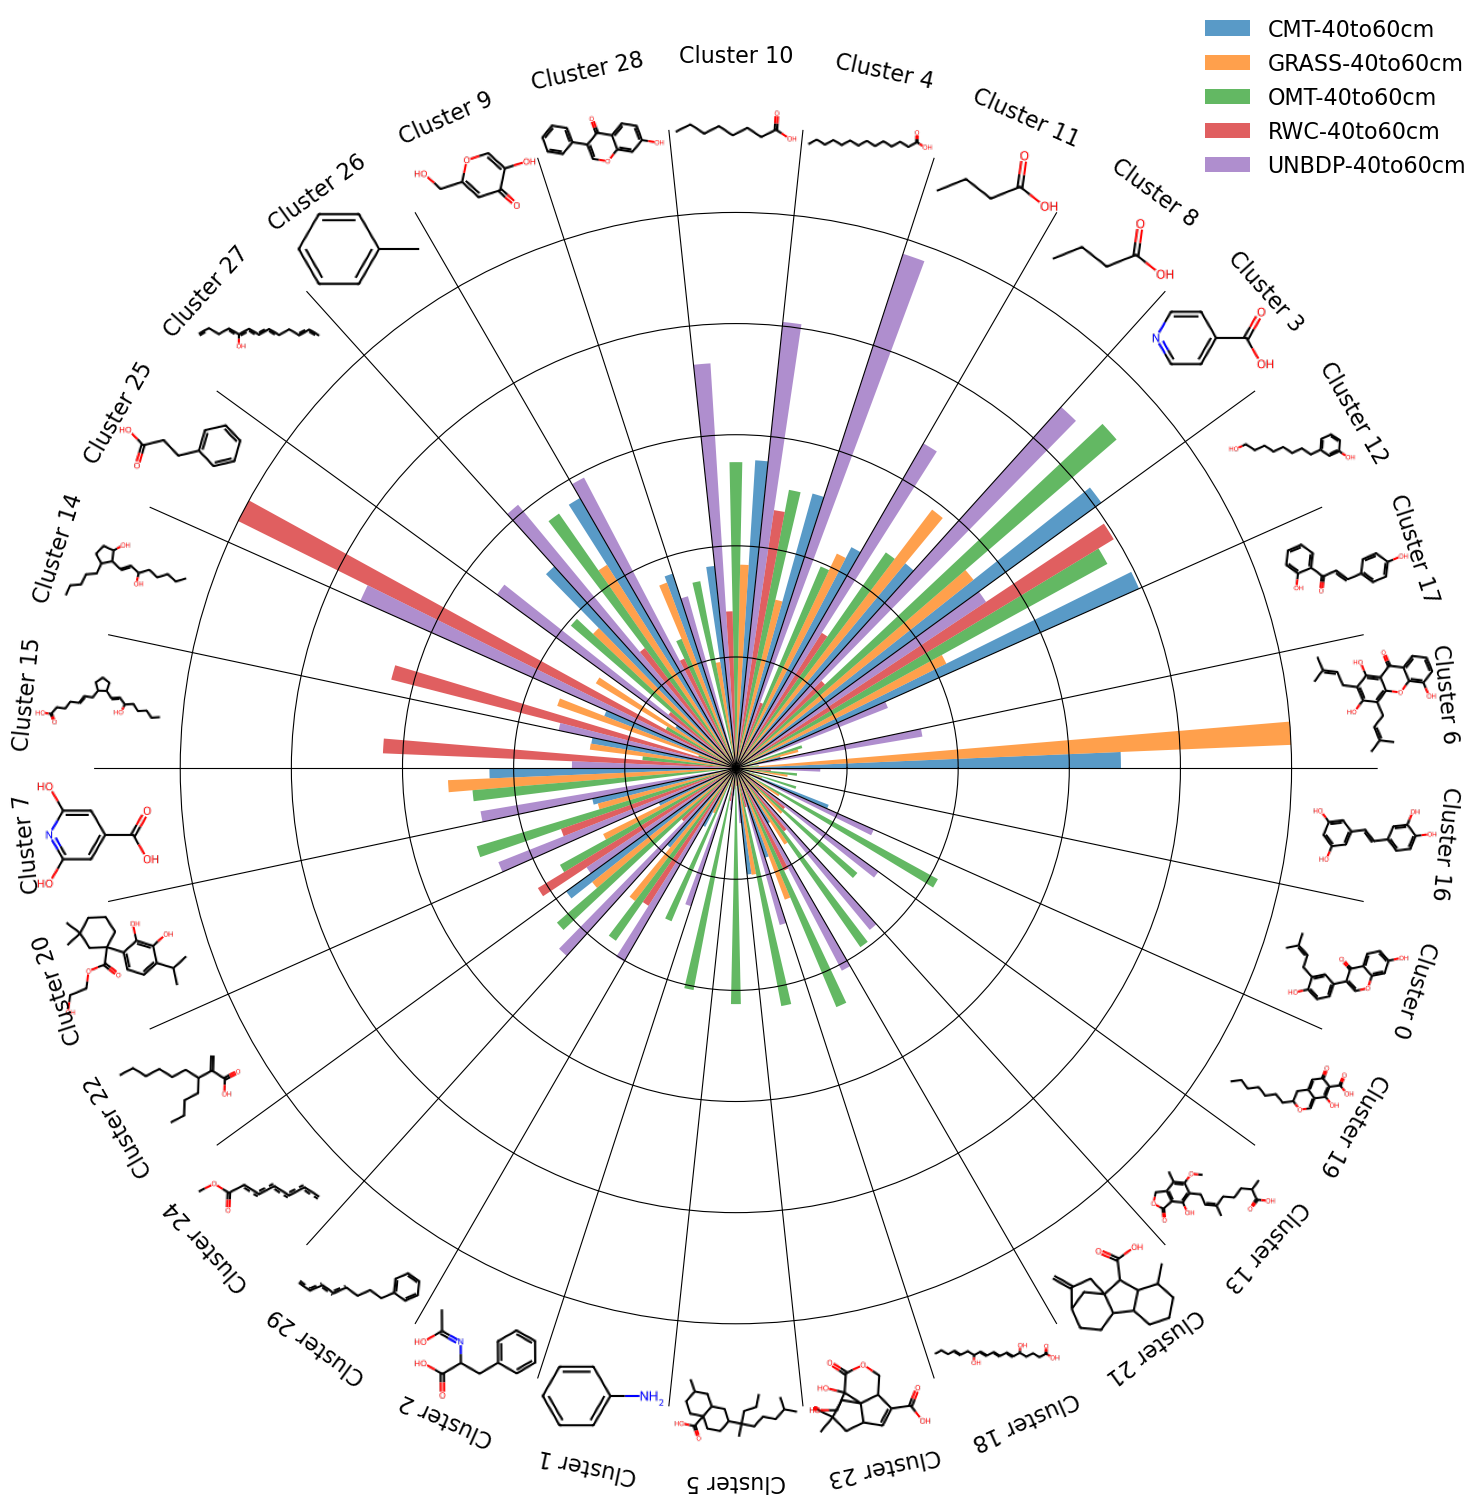

In [56]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from rdkit import Chem
from rdkit.Chem import Draw
# Create the polar plot
def make_polar_structural_cluster_plot(cluster_df,file_str=''):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15), subplot_kw={'projection': 'polar'})

    # Define the angles for each side of the polygons
    angles = np.linspace(0, 2 * np.pi, cluster_df.shape[0] + 1)[:-1]
    shift_amount = np.diff(angles)[0] / cluster_df.shape[1]
    for iii in range(cluster_df.shape[1]):
        # Define the lengths of the bars
        bar_lengths = cluster_df.values[:, iii]
        # Plot the bars
        ax.bar(angles + iii * shift_amount, bar_lengths*1, width=shift_amount, align='edge', alpha=0.74, label=cluster_df.columns[iii].replace('Quant: ',''))

    # Set the labels for each side of the polygons
    ax.set_xticks(angles)
    ax.set_xticklabels(['' for i in range(cluster_df.shape[0])])

    # Set the title of the plot
    tick_labels = ax.xaxis.get_ticklabels()

    m = ax.get_ylim()[1]*1.1
    ax.set_ylim(0, m)

    from PIL import Image
    from io import BytesIO
    def show_mol(d2d,mol,legend='',highlightAtoms=[]):
        d2d.DrawMolecule(mol)#,legend=legend, highlightAtoms=highlightAtoms)
        d2d.FinishDrawing()
        bio = BytesIO(d2d.GetDrawingText())
        return Image.open(bio)

    counter = 0
    for i, row in cluster_df.iterrows():
        mol = Chem.MolFromSmarts(i[1])
        s = Chem.MolToSmiles(mol)
        mol = Chem.MolFromSmiles(s)
        d2d = Draw.MolDraw2DCairo(120, 120)
        dopts = d2d.drawOptions()
        dopts.setBackgroundColour((0, 0, 0, 0))
        im = show_mol(d2d, mol)

        imagebox = OffsetImage(im, zoom=0.8)
        ax.add_artist(AnnotationBbox(imagebox, (angles[counter] + shift_amount*cluster_df.shape[1]/2, m * 1), frameon=False))
        # if np.cos(angles[counter]) < 0:
        # my_angle = angles[counter] + shift_amount*2 - np.pi
        # else:
        my_angle = angles[counter] + shift_amount* cluster_df.shape[1]/2
        # my_angle = angles[counter] + shift_amount*2
        my_angle = my_angle * 180/np.pi - 90
        ax.text(angles[counter] + shift_amount*cluster_df.shape[1]/2, m * 1.11, 'Cluster %d'%i[0], ha='center', va='center', fontsize=16, rotation=my_angle)#angles[counter]*180/4/np.pi)


        counter += 1

    ax.spines['polar'].set_visible(False)
    ax.grid(color='black')
    # Hide the y tick labels
    ax.set_yticklabels([])

    # Position the legend outside of the plot area
    ax.legend(bbox_to_anchor=(0.85, 1.1), loc='upper left',fontsize=16,frameon=False)

    plt.tight_layout()
    fig.savefig('lcms-structural_cluster_plot_%s.pdf'%file_str)#, dpi=300)

# cols = [c for c in cluster_df.columns if ('deciduousforests' in c) | ('coniferousforests' in c)]
# cols = [c for c in cluster_df.columns if ('OMT' in c) | ('CMT' in c)]
cols = [c for c in cluster_df.columns if ('40to60' in c)]
# cols = [c for c in cluster_df.columns if ('UNBDP' in c) | ('OMT' in c)]
make_polar_structural_cluster_plot(cluster_df[cols],'Quant-Century-Environment-Depth-40to60')

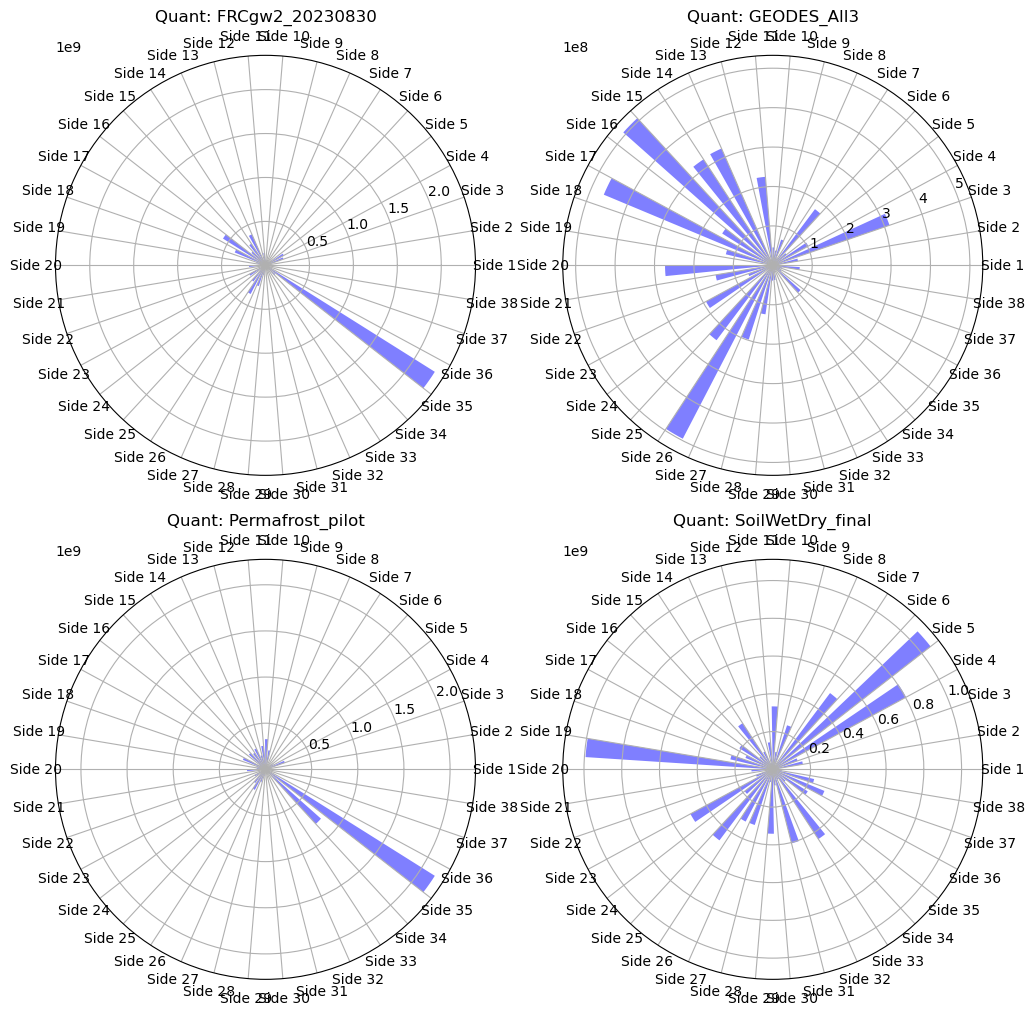

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of sides of the polygons
num_sides = bar_df.shape[0]

# Define the angles for each side of the polygons
angles = np.linspace(0, 2 * np.pi, num_sides + 1)[:-1]



# Create the polar plot
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12),subplot_kw={'projection': 'polar'})
ax = ax.flatten()

for i in range(len(ax)):
    # Define the lengths of the bars
    bar_lengths = bar_df.values[:,i]
    # Plot the bars
    ax[i].bar(angles, bar_lengths, width=0.1, align='edge', color='blue', alpha=0.5)


    # Set the labels for each side of the polygons
    ax[i].set_xticks(angles)
    ax[i].set_xticklabels(['Side {}'.format(i+1) for i in range(num_sides)])

    # Set the title of the plot
    ax[i].set_title(bar_df.columns[i])

# Show the plot
plt.show()


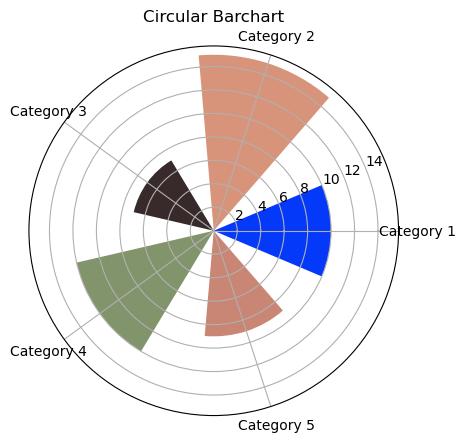

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = ['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']
values = [10, 15, 7, 12, 9]

# Convert values to radians
theta = np.linspace(0.0, 2 * np.pi, len(categories), endpoint=False)

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
bars = ax.bar(theta, values)

# Set the color of each bar
for bar in bars:
    bar.set_facecolor(np.random.rand(3))

# Set the labels for each category
ax.set_xticks(theta)
ax.set_xticklabels(categories)

# Set the title of the plot
ax.set_title('Circular Barchart')

# Show the plot
plt.show()
